# Univariate DCMM

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.special
import scipy.optimize

/Users/zhuoqunwang/anaconda3/envs/tf/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/zhuoqunwang/anaconda3/envs/tf/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Simulate time series

265.0


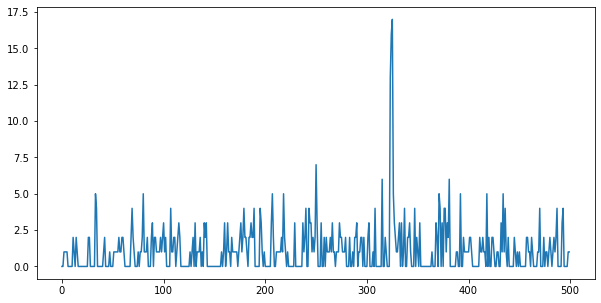

In [3]:
np.random.seed(2)
class DGLM(object):
    def __init__(self,m0_,C0_,Wt_,d_):
        self.m0=m0_
        self.c0=C0_
        self.wt=Wt_
        self.dtheta=d_
        self.mt=m0_
        self.ct=C0_
        self.at=m0_
        self.alphat=1
        self.betat=1
        self.rt=np.zeros(d_)
    def up_at(self,Gt):
        self.at=np.dot(Gt,self.mt)
    def up_rt(self,Gt):
        self.rt=np.dot(Gt.dot(self.ct),Gt.T)+self.wt
    def solveab(self,fq):
        sol=scipy.optimize.root(fq, np.array([1,1])).x
        #sol=scipy.optimize.broyden1(fq, np.array([1,1]), f_tol=1)
        self.alphat=sol[0]
        self.betat=sol[1]
    def forecast1(self):
        return(self.alphat/(self.alphat+self.betat))
    def gt(self,zt):
        return(scipy.special.digamma(self.alphat+zt)-scipy.special.digamma(self.betat+1-zt))
    def pt(self,zt):
        return(scipy.special.polygamma(1,self.alphat+zt)+scipy.special.polygamma(1,self.betat+1-zt))
    def ft(self,Ft):
        return((Ft.T).dot(self.at))
        #return(scipy.special.digamma(self.alphat)-scipy.special.digamma(self.betat))
    def qt(self,Ft):
        return((Ft.T).dot(self.rt).dot(Ft))
    def post_up_mt(self,gtn,ftn,ptn,qtn,Ft):
        #print('g===',gtn,'f===',ftn,'p===',ptn,'q===',qtn,'F===',Ft)
        self.mt=self.at+self.rt.dot(Ft)*(gtn-ftn)/qtn
    def post_up_ct(self,gtn,ftn,ptn,qtn,Ft):
        #print('here!','self.rt:',self.rt,'Ft:',Ft,'(self.rt.dot(Ft)).dot(Ft.T):',(self.rt.dot(Ft.T)))
        self.ct=self.rt-((self.rt.dot(Ft.reshape([2,1]))).dot(Ft.reshape([1,2]))).dot(self.rt.T)*(1-ptn/qtn)/qtn
#state vector 2d
#initialization
ksi_dglm=DGLM(np.array([1,1]),np.identity(2),np.identity(2)/2,2)
mu_dglm=DGLM(np.array([1,1]),np.identity(2),np.identity(2)/2,2)
G_ksi_t=np.array([[0.5,0],[0,0.5]])#rotate pi/2
G_mu_t=np.array([[0.8,0],[0,0.8]])#rotate pi/2
F_ksi_t=np.array([-3,-10])
F_mu_t=np.array([0.3,0.1])
W_ksi_t=np.identity(2)
W_mu_t=np.identity(2)
F_theta_t=np.array([0.3,0.4])
W_theta_t=np.identity(2)

N=500

theta0=np.array([1,1])
ksi0=np.array([1,1])
theta=theta0
ksi=ksi0

z=np.zeros(N)
y=np.zeros(N)

#simulate a sparse series
for t in range(N):
    lam_ksi=np.dot(F_ksi_t,ksi)
    lam_theta=np.dot(F_theta_t,theta)
    #print(lam_ksi)
    pi=scipy.special.expit(lam_ksi)
    mu=np.exp(lam_theta)
    zt=np.random.binomial(1,pi)
    z[t]=zt
    if zt==1:
        yt=1+np.random.poisson(mu)
        y[t]=yt
    #y is the output series!
    ksi=np.dot(G_ksi_t,ksi)+np.random.multivariate_normal(np.zeros(2),W_ksi_t)
    theta=np.dot(G_mu_t,theta)+np.random.multivariate_normal(np.zeros(2),W_theta_t)
plt.figure(figsize=(10,5))
plt.plot(y)
print(np.sum(z))


## 1-step ahead predictive distribution & updating with DCMM

In [8]:
z_forecast=np.zeros(N)
y_pred_uncond=np.zeros(N)
y_pred_up1sd=np.zeros(N)
y_pred_low1sd=np.zeros(N)
for t in range(1,N):
    #update ksi
    ##do appendix 1 in order
    Gt=G_ksi_t
    Ft=F_ksi_t
    ksi_dglm.up_at(Gt)
    ksi_dglm.up_rt(Gt)
    ftnum=ksi_dglm.ft(Ft)
    qtnum=ksi_dglm.qt(Ft)
    def fq(ab):
        return([scipy.special.digamma(ab[0])-scipy.special.digamma(ab[1])-ftnum,scipy.special.polygamma(1,ab[0])+scipy.special.polygamma(1,ab[1])-qtnum])
    ksi_dglm.solveab(fq)
    z_forecast[t]=ksi_dglm.forecast1()
    gtnum=ksi_dglm.gt(z[t])
    ptnum=ksi_dglm.pt(z[t])
    ##posterior update
    ksi_dglm.post_up_mt(gtnum,ftnum,ptnum,qtnum,Ft)
    ksi_dglm.post_up_ct(gtnum,ftnum,ptnum,qtnum,Ft)
    #update mu if z=1
    Gt=G_mu_t
    Ft=F_mu_t
    mu_dglm.up_at(Gt)
    mu_dglm.up_rt(Gt)
    ftnum=mu_dglm.ft(Ft)
    qtnum=mu_dglm.qt(Ft)
    def fq(ab):
        return([scipy.special.digamma(ab[0])-np.log(ab[1])-ftnum,scipy.special.polygamma(1,ab[0])-qtnum])
    mu_dglm.solveab(fq)
    ##one step ahead predictive distribution: Bernoulli-NB mixture
    nb_r=mu_dglm.alphat
    nb_p=mu_dglm.betat/(1+mu_dglm.betat)
    #ez=z_forecast[t]
    #ypredictive=np.zeros(10000)
    #zrand=np.zeros(10000)
    #for i in range(10000):
    #    zrand[i]=np.random.binomial(1,ez)
    #    ypredictive[i]=0*(1-zrand[i])+np.random.negative_binomial(nb_r,1-nb_p)*(1-zrand[i])
    #khat=10000/np.sum(1/ypredictive)
    #pi0hat=np.sum(zrand)
    #qhat=(1-khat*pi0hat)/2
    if z[t]==1:
        ##calculate gt and pt
        gtnum=scipy.special.digamma(mu_dglm.alphat+y[t])-np.log(mu_dglm.betat+1)
        ptnum=scipy.special.polygamma(1,mu_dglm.alphat+y[t])
        ##posterior update
        mu_dglm.post_up_mt(gtnum,ftnum,ptnum,qtnum,Ft)
        mu_dglm.post_up_ct(gtnum,ftnum,ptnum,qtnum,Ft)
        